# Process Michilli Bursts

This notebook computes the burst drift for all Michilli et al. 2018 bursts using the method show in `BurstDrift.ipynb`

In [4]:
#!/usr/bin/python3

from __future__ import division
import math
import os
import sys
import time
import numpy as np
import scipy.stats
from scipy.optimize import curve_fit
from math import log10
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import pi as nombrepi
from scipy import signal, ndimage
from tqdm import tqdm
from matplotlib import colors as mcolors
import functools
print = functools.partial(print, flush=True) # print doesn't happen til script ends so force it to flush... windows thing?
import pandas as pd
import corrfns
import itertools

bursts = pd.read_csv('bursts.csv')

# Gaussian 2d Fit Stuff
# Source: https://gist.github.com/andrewgiessel/6122739
# Source: https://stackoverflow.com/questions/21566379/fitting-a-2d-gaussian-function-using-scipy-optimize-curve-fit-valueerror-and-m
def gaussian(height, center_x, center_y, width_x, width_y, rotation):
    """Returns a gaussian function with the given parameters"""
    width_x = float(width_x)
    width_y = float(width_y)

    rotation = np.deg2rad(rotation)
    center_x_old = center_x
    center_x = center_x * np.cos(rotation) - center_y * np.sin(rotation)
    center_y = center_x_old * np.sin(rotation) + center_y * np.cos(rotation)

    def rotgauss(x,y):
        xp = x * np.cos(rotation) - y * np.sin(rotation)
        yp = x * np.sin(rotation) + y * np.cos(rotation)
        g = height*np.exp( -(((center_x-xp)/width_x)**2  +((center_y-yp)/width_y)**2)/2.  )
        return g
    return rotgauss

def moments(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    total = data.sum()
    X, Y = np.indices(data.shape)
    x = (X*data).sum()/total
    y = (Y*data).sum()/total
    col = data[:, int(y)]
    width_x = np.sqrt(abs((np.arange(col.size)-y)**2*col).sum()/col.sum())
    row = data[int(x), :]
    width_y = np.sqrt(abs((np.arange(row.size)-x)**2*row).sum()/row.sum())
    height = data.max()
    return height, x, y, width_x, width_y, 2.0

def twoD_Gaussian(point, amplitude, xo, yo, sigma_x, sigma_y, theta):
    x, y = point
    xo = float(xo)
    yo = float(yo)
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = (np.sin(2*theta))/(2*sigma_x**2) - (np.sin(2*theta))/(2*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = amplitude*np.exp( - a*((x-xo)**2) - b*(x-xo)*(y-yo) - c*((y-yo)**2))
    return g.ravel()

def fitgaussian(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution found by a fit"""
    params = moments(data)
    errorfunction = lambda p: np.ravel(gaussian(*p)(*np.indices(data.shape)) - data)
    p, success = scipy.optimize.leastsq(errorfunction, params)
    return p, success

def fitgaussiannlsq(data, sigma=0):
    # use curve-fit (non-linear leastsq)
    x = range(0, 1023); y = range(0, 1023)
    x, y = np.meshgrid(x, y)
    params = moments(data)#+ (0.,)
    sigma = np.zeros(len(data.ravel())) + sigma
    popt, pcov = scipy.optimize.curve_fit(twoD_Gaussian, (x, y), data.ravel(), p0=params, sigma=sigma, absolute_sigma=True)
    return popt, pcov

def dedisperse(intensity, DM, nu_low, df_mhz, dt_ms, cshift=0):
    dedispersed = np.copy(intensity)

    shifts = [0 for i in range(0, len(intensity))]
    high_ref_freq = nu_low + len(dedispersed)*df_mhz
    low_ref_freq  = nu_low
    #k_dm = 4.1488064239e6 # kulkarni
    k_dm = 4.14937759336e6 # pulsar community
    for i, row in enumerate(dedispersed): # i == 0 corresponds to bottom of the band
        nu_i = nu_low + i*df_mhz
        # High frequency anchor
        deltat = - k_dm * (nu_i**-2 - high_ref_freq**-2) * DM

        # Low frequency anchor
        #deltat = 4.14937759336e6 * (low_ref_freq**-2 - nu_i**-2) * DM

        channelshift = int(round(deltat/dt_ms))
        dedispersed[i] = np.roll(dedispersed[i], channelshift)

    # optionally center view
    dedispersed = np.roll(dedispersed, cshift, axis=1)

    return dedispersed

def findCenter(burstwindow):
    #freqspectrum = np.nanmean(burstwindow, axis=1)
    # To be honest I wrote this with pandas a long time ago and I'm not sure why but it works
    freqspectrum = pd.DataFrame(burstwindow.sum(axis=1)[:, None])
    data = freqspectrum[:][0]
    x = data.keys()
    xo = sum(x*data)/sum(data)
    return xo # return the central frequency 

################
folder        = 'data'
outfolder     = 'figures'
parameterfile = 'frb121102params.csv'

sigmax_error = []
sigmay_error = []
angle_error  = []
drift_errors = []
drifts       = []
autocorrs    = []
auto_sigmas  = []
red_chisqs   = []
if os.path.exists(parameterfile) and False:
    popts = pd.read_csv(parameterfile, index_col=0)[['amplitude', 'xo', 'yo', 'sigmax', 'sigmay', 'theta']]
    perrs = pd.read_csv(parameterfile, index_col=0)[['amp_error', 'xo_error', 'yo_error', 'sigmax_error', 'sigmay_error', 'angle_error']]
else:
    popts, perrs = [], []

corredges = [(10, 300),
             (10, 300),
             (10, 300),
             (10, 300),
             (10, 300),
             (10, 250),
             (10, 300),
             (10, 250),
             (10, 300),
             (10, 300),
             (10, 300),
             (10, 300),
             (10, 300),
             (10, 300),
             (10, 300),
             (10, 300)]

# Stuff for figure 4
burst2data = {}
burst3data = {}

### Stuff for DM/drift covariance
centerDM = 559.7 # pc/cm^3
leftDM = centerDM*0.99, centerDM*1.01 # "any bona fide dispersion measure variations are at the <= 1% level" - Michilli et al. 2018
trialDMs = np.append(np.linspace(centerDM*0.99, centerDM*1.01, num=20), centerDM)
DMcovariancedata = []
popt_custom = []
#trialDMs = [centerDM]

for trialDM in trialDMs:
    ploti = itertools.count(start=1, step=1)
    #plt.figure(figsize=(24, 36))
    plt.figure(figsize=(8.5*2, 11*2))
    for burst, filename, edge, burstname in tqdm( zip(range(1, len(bursts['filename'])+1), bursts['filename'], bursts['edge'], bursts['name']), total=len(bursts['filename']) ):
        if 'gajjar' in filename:
            continue
        if burst in [9, 10]:
            continue
        if burst > 16:
            continue
        #print('processing {}'.format(filename))
        #junk, nchan, nbin, I, Q, U, V = np.loadtxt('{}/{}'.format(folder, filename), delimiter=' ', unpack=True)
        #Q, U, V = None, None, None

        junk, nchan, nbin, I = [], [], [], []
        with open('{}/{}'.format(folder, filename)) as infile:
            for line in infile:
                junki, nchani, nbini, Ii, _, _, _ = line.split(' ')
                junk.append(junki)
                nchan.append(nchani)
                nbin.append(nbini)
                I.append(Ii)
        junk  = np.array(junk, dtype=float)
        nchan = np.array(nchan, dtype=float)
        nbin  = np.array(nbin, dtype=float)
        I     = np.array(I, dtype=float)

        n = len(junk)
        edge = int(edge)
        # print("Data loaded")

        binmax = int(nbin[n-1])+1
        frequencymax = (int(nchan[n-1])+1)
        intensity = np.zeros((frequencymax, binmax))

        X = np.zeros(binmax)
        Y = np.zeros(frequencymax)

        # what are these?
        tmin = 500 
        tmax = 1500

        #### 1. remove noise
        intensitynoise1 = np.zeros(tmin-1)
        intensitynoise2 = np.zeros(binmax-tmax)
        for i in tqdm(range(frequencymax-50,51,-1), desc='noise removal', disable=True):

            Y[i-1] = 4.15 + (i-1) * 1.5625 # ?

            for j in range(1,tmin) :

                intensitynoise1[j-1] = (I[j-1 + binmax*(frequencymax-i)])/(tmin-1)


            for j in range(tmax+1,binmax+1) :

                intensitynoise2[j-1-tmax] = (I[j-1 + binmax*(frequencymax-i)])/(binmax-tmax)

            a = sum(intensitynoise1)
            b = sum(intensitynoise2)

            for j in range(1,binmax+1) :
                X[j-1] = j-1
                intensity[i-1,j-1] = I[j-1 + binmax*(frequencymax-i)] - (a+b)/2

        #### 2. find autocorrelation 
        burstwindow = intensity[:,edge:edge+frequencymax]
        ddm = trialDM - centerDM
        burstwindow = dedisperse(burstwindow, ddm, 4100.78125, 1.5625, 0.01024)

        # print("finding auto-correlation...")
        #corr = signal.correlate2d(burstwindow, burstwindow, mode='full')
        #print(corr.shape)
        corr = corrfns.auto_corr2D_viafft(burstwindow)

        #### 2.5 Autocorr noise
        autocorr_sigma = np.std( corr[:, corredges[burst-1][0]:corredges[burst-1][1]] )
        # print('autocorr_sigma', autocorr_sigma)
        auto_sigmas.append(autocorr_sigma)

        #### 3. Fit Gaussian to autocorrelation. Load from parameter file if already found.
        # if os.path.exists(parameterfile) and ddm == 0:
        if type(popts) != list:
            #print('loading fit...')
            # popt is [amplitude, xo, yo, sigma_x, sigma_y, theta]
            popt, perr = popts.iloc[burst-1], perrs.iloc[burst-1]
        else:        
            print("finding fit...")
            try:
                popt, pcov = fitgaussiannlsq(corr, sigma=autocorr_sigma)
                perr = np.sqrt(np.diag(pcov))
            except (RuntimeError, ValueError):
                print('no fit found')
                popt, perr = [-1,-1,-1,-1,-1,-1], [-1,-1,-1,-1,-1,-1]
                if popt_custom != []:
                    popt = popt_custom
        popts.append(popt)
        perrs.append(perr)
        
        #### 3. Fit Gaussian to autocorrelation
        x = range(0, 1023); y = range(0, 1023)
        x, y = np.meshgrid(x, y)
        fitmap2 = twoD_Gaussian((x, y), *popt).reshape(1023, 1023)
        # print('solution nlsq:', popt)
        # print('parameter 1sigma:', perr)
        # print('pcov diag:', np.diag(pcov))
        # with np.printoptions(precision=3, suppress=True):
            # print('pcov:')
            # print(pcov)

        # calculate reduced chisquared
        residuals = corr - fitmap2
        chisq = np.sum((residuals / autocorr_sigma) ** 2)
        red_chisq = chisq / (corr.shape[0]*corr.shape[1] - len(popt)) # this is chisq/(M-N)
        red_chisqs.append(red_chisq)
        # print('reduced chisq:', red_chisq)

        ### 3.5 Compute drift and error
        theta = popt[5] if abs(popt[3]) > abs(popt[4]) else popt[5] - np.pi/2
        popt[5] = theta
        # print('solver angle:', popt[-1], 'pos angle:', theta)
        slope = np.tan(theta)
        drift = 1.5625/0.01024 * slope # MHz/ms
        drift_error = (1.5625/0.01024) * (perr[-1] * (1/np.cos(theta))**2)
        sigmax_error.append(perr[3])
        sigmay_error.append(perr[4])
        angle_error.append(perr[5])
        drift_errors.append(drift_error)  
        drifts.append(drift)    
        #print('drift:', drift, "pm", drift_error)
        
        # find center frequency
        freq_res = 1.5625 # MHz
        lowest_freq = 4100.78125 # MHz
        center_f = (findCenter(burstwindow)*freq_res + lowest_freq)/1000
        
        ## DM covariance data: each row is [burst, trialdm, drift, drift_error, popt(6), perr(6)]
        DMcovariancedata.append(np.concatenate(([burst, trialDM, center_f*1000, drift, drift_error, red_chisq], popt, perr)))
        
        #### 4. Plot
        cmap = plt.get_cmap('gray')
        cmap.set_bad(color = 'k', alpha = 1.) # potentially hides important errors in the data!
        fontsize = 15 # 5

        #plt.figure(figsize=(17,8))
        #plt.subplot(121)

        plt.subplot(7, 4, next(ploti))
        plt.title("Burst #{}".format(burst), size=fontsize)
        burstextents = [0, 
               10.24e-6 * burstwindow.shape[-1] * 1e3, 
               4100.78125 * 1e-3, 
               (4100.78125 + 1.5625*burstwindow.shape[-2]) * 1e-3]
        plt.imshow(burstwindow, cmap=cmap, interpolation='bicubic',aspect='auto', origin="lower", extent=burstextents)
        plt.axhline(y=center_f, c='k', ls='--')
        plt.xlabel("Time (ms)", size=fontsize)
        plt.ylabel("Frequency (GHz)", size=fontsize)
        plt.xticks(fontsize=fontsize)
        plt.yticks(fontsize=fontsize)

        #plt.subplot(122)
        plt.subplot(7, 4, next(ploti))
        #plt.title("Corr #{}. $\\nu_D$ = {:.2f} MHz/ms $\pm$ {:.2E}, peak = {:.0f}, $\sigma_x$ = {:.0f} $\sigma_y$ = {:.0f}".format(burst, drift, drift_error, np.max(corr), popt[3], popt[4]))
        #plt.title("Corr #{}. $\\nu_D$ = {:.2f} MHz/ms $\pm$ {:.2E}, $\sigma_x$ = {:.0f} $\sigma_y$ = {:.0f}, tdm = {:.2f}".format(burst, drift, drift_error, popt[3], popt[4], trialDM))
        #plt.title("Corr #{}. $\\nu_D$ = {:.2f} MHz/ms $\pm$ {:.2E}".format(burst, drift, drift_error))
        plt.title("Corr #{}".format(burst), size=fontsize)

        corrextents = [-10.24e-6 * (corr.shape[1]/2) * 1e3, 
               10.24e-6 * (corr.shape[1]/2) * 1e3 , 
               (4100.78125 -  (2*4100.78125 + 1.5625*burstwindow.shape[0])/2 )*2, 
               ((4100.78125 + 1.5625*burstwindow.shape[-2]) -  (2*4100.78125 + 1.5625*burstwindow.shape[0])/2 )*2]
        #plt.imshow(corr, cmap=cmap, interpolation='bicubic',aspect='auto', origin="lower") # linear scale
        #plt.clim(0, np.max(corr)/10)
        plt.imshow(corr, cmap=cmap, interpolation='bicubic', aspect='auto', origin="lower", norm=mcolors.LogNorm(vmin=1), extent=corrextents)
        plt.xlabel("Time Shift (ms)", size=fontsize)
        plt.ylabel("Frequency Shift (MHz)", size=fontsize)
        plt.xticks(fontsize=fontsize)
        plt.yticks(fontsize=fontsize)

        if popt[0] > 0:
            plt.contour(fitmap2, [popt[0]/4, popt[0]*0.9], colors='w', alpha=0.5, origin='lower', extent=corrextents)

        if burst == 2: 
            burst2data['corr'] = corr
            burst2data['burstwindow'] = burstwindow
            burst2data['fitmap'] = fitmap2
            burst2data['popt']  = popt
        if burst == 3:
            burst3data['corr'] = corr
            burst3data['burstwindow'] = burstwindow
            burst3data['fitmap'] = fitmap2
            burst3data['popt']  = popt

        # plt.tight_layout()
        # print('saved {}/burst_{}_figure.png'.format(outfolder, burst))
    plt.tight_layout()
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
    plt.savefig('{}/frb121102_dm_{}.png'.format(outfolder, trialDM))
    plt.savefig('{}/frb121102_dm_{}.pdf'.format(outfolder, trialDM))
    plt.close()

  0%|          | 0/28 [00:00<?, ?it/s]

finding fit...


<ipython-input-4-fb2862e6c76c>:311: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gray"))
  cmap.set_bad(color = 'k', alpha = 1.) # potentially hides important errors in the data!
  4%|▎         | 1/28 [00:14<06:37, 14.73s/it]

finding fit...


  7%|▋         | 2/28 [00:33<06:56, 16.02s/it]

finding fit...


 11%|█         | 3/28 [00:53<07:09, 17.18s/it]

finding fit...


 14%|█▍        | 4/28 [01:12<07:02, 17.60s/it]

finding fit...


 18%|█▊        | 5/28 [01:28<06:32, 17.07s/it]

finding fit...


 21%|██▏       | 6/28 [01:47<06:32, 17.82s/it]

finding fit...


 25%|██▌       | 7/28 [02:03<06:02, 17.28s/it]

finding fit...


 29%|██▊       | 8/28 [02:18<05:29, 16.45s/it]

finding fit...


 39%|███▉      | 11/28 [02:33<03:41, 13.05s/it]

finding fit...


 43%|████▎     | 12/28 [02:50<03:48, 14.30s/it]

finding fit...


 46%|████▋     | 13/28 [03:05<03:35, 14.37s/it]

finding fit...


 50%|█████     | 14/28 [03:23<03:36, 15.48s/it]

finding fit...


 54%|█████▎    | 15/28 [03:41<03:32, 16.36s/it]

finding fit...


  0%|          | 0/28 [00:00<?, ?it/s]

finding fit...


B:\dev\sadtrombone\corrfns.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  temp_array_a[0:nx,:] = result_shifted[nx-1:2*nx-1,:]
B:\dev\sadtrombone\corrfns.py:53: ComplexWarning: Casting complex values to real discards the imaginary part
  temp_array_a[nx:2*nx-1,:] = result_shifted[0:nx-1,:]
<ipython-input-4-fb2862e6c76c>:311: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gray"))
  cmap.set_bad(color = 'k', alpha = 1.) # potentially hides important errors in the data!
  4%|▎         | 1/28 [00:14<06:36, 14.67s/it]

finding fit...


  7%|▋         | 2/28 [00:33<06:57, 16.04s/it]

finding fit...


 11%|█         | 3/28 [00:55<07:21, 17.68s/it]

finding fit...


 14%|█▍        | 4/28 [01:09<06:38, 16.60s/it]

finding fit...


 18%|█▊        | 5/28 [01:26<06:21, 16.58s/it]

finding fit...


 21%|██▏       | 6/28 [01:45<06:25, 17.53s/it]

finding fit...


 25%|██▌       | 7/28 [02:00<05:51, 16.75s/it]

finding fit...


 29%|██▊       | 8/28 [02:15<05:22, 16.11s/it]

finding fit...


 39%|███▉      | 11/28 [02:30<03:37, 12.82s/it]

finding fit...


 43%|████▎     | 12/28 [02:50<03:57, 14.84s/it]

finding fit...


 46%|████▋     | 13/28 [03:04<03:40, 14.71s/it]

finding fit...


 50%|█████     | 14/28 [03:23<03:44, 16.03s/it]

finding fit...


 54%|█████▎    | 15/28 [03:45<03:49, 17.66s/it]

finding fit...


  0%|          | 0/28 [00:00<?, ?it/s]

finding fit...


B:\dev\sadtrombone\corrfns.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  temp_array_a[0:nx,:] = result_shifted[nx-1:2*nx-1,:]
B:\dev\sadtrombone\corrfns.py:53: ComplexWarning: Casting complex values to real discards the imaginary part
  temp_array_a[nx:2*nx-1,:] = result_shifted[0:nx-1,:]
<ipython-input-4-fb2862e6c76c>:311: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gray"))
  cmap.set_bad(color = 'k', alpha = 1.) # potentially hides important errors in the data!
  4%|▎         | 1/28 [00:14<06:26, 14.33s/it]

finding fit...


  7%|▋         | 2/28 [00:32<06:40, 15.38s/it]

finding fit...


 11%|█         | 3/28 [00:51<06:51, 16.44s/it]

finding fit...


 14%|█▍        | 4/28 [01:06<06:25, 16.08s/it]

finding fit...


 18%|█▊        | 5/28 [01:22<06:10, 16.11s/it]

finding fit...


 21%|██▏       | 6/28 [01:41<06:13, 16.99s/it]

finding fit...


 25%|██▌       | 7/28 [02:07<06:51, 19.61s/it]

finding fit...


 29%|██▊       | 8/28 [02:21<06:00, 18.02s/it]

finding fit...


 39%|███▉      | 11/28 [02:37<04:00, 14.17s/it]

finding fit...


 43%|████▎     | 12/28 [02:56<04:12, 15.78s/it]

finding fit...


 46%|████▋     | 13/28 [03:11<03:50, 15.38s/it]

finding fit...


 50%|█████     | 14/28 [03:31<03:57, 16.99s/it]

finding fit...


 54%|█████▎    | 15/28 [03:56<04:10, 19.28s/it]

finding fit...


  0%|          | 0/28 [00:00<?, ?it/s]

finding fit...


B:\dev\sadtrombone\corrfns.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  temp_array_a[0:nx,:] = result_shifted[nx-1:2*nx-1,:]
B:\dev\sadtrombone\corrfns.py:53: ComplexWarning: Casting complex values to real discards the imaginary part
  temp_array_a[nx:2*nx-1,:] = result_shifted[0:nx-1,:]
<ipython-input-4-fb2862e6c76c>:311: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gray"))
  cmap.set_bad(color = 'k', alpha = 1.) # potentially hides important errors in the data!
  4%|▎         | 1/28 [00:14<06:36, 14.68s/it]

finding fit...


  7%|▋         | 2/28 [00:30<06:32, 15.08s/it]

finding fit...


 11%|█         | 3/28 [00:53<07:17, 17.49s/it]

finding fit...
no fit found


 14%|█▍        | 4/28 [03:59<27:09, 67.91s/it]

finding fit...


 18%|█▊        | 5/28 [04:15<20:02, 52.28s/it]

finding fit...


 21%|██▏       | 6/28 [04:34<15:30, 42.27s/it]

finding fit...


 25%|██▌       | 7/28 [05:17<14:54, 42.60s/it]

finding fit...


 29%|██▊       | 8/28 [05:31<11:21, 34.09s/it]

finding fit...


 39%|███▉      | 11/28 [05:46<07:10, 25.32s/it]

finding fit...


 43%|████▎     | 12/28 [06:05<06:15, 23.46s/it]

finding fit...


 46%|████▋     | 13/28 [06:19<05:10, 20.67s/it]

finding fit...


 50%|█████     | 14/28 [06:40<04:52, 20.86s/it]

finding fit...


 54%|█████▎    | 15/28 [06:59<04:23, 20.23s/it]

finding fit...


  0%|          | 0/28 [00:00<?, ?it/s]

finding fit...


B:\dev\sadtrombone\corrfns.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  temp_array_a[0:nx,:] = result_shifted[nx-1:2*nx-1,:]
B:\dev\sadtrombone\corrfns.py:53: ComplexWarning: Casting complex values to real discards the imaginary part
  temp_array_a[nx:2*nx-1,:] = result_shifted[0:nx-1,:]
<ipython-input-4-fb2862e6c76c>:311: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gray"))
  cmap.set_bad(color = 'k', alpha = 1.) # potentially hides important errors in the data!
  4%|▎         | 1/28 [00:17<07:46, 17.29s/it]

finding fit...


  7%|▋         | 2/28 [00:33<07:18, 16.86s/it]

finding fit...


 11%|█         | 3/28 [00:52<07:22, 17.71s/it]

finding fit...


 14%|█▍        | 4/28 [01:10<07:04, 17.68s/it]

finding fit...


 18%|█▊        | 5/28 [01:26<06:38, 17.33s/it]

finding fit...


 21%|██▏       | 6/28 [01:45<06:32, 17.82s/it]

finding fit...


 25%|██▌       | 7/28 [02:11<06:59, 19.99s/it]

finding fit...


 29%|██▊       | 8/28 [02:25<06:05, 18.29s/it]

finding fit...


 39%|███▉      | 11/28 [02:39<04:02, 14.25s/it]

finding fit...


 43%|████▎     | 12/28 [02:58<04:10, 15.63s/it]

finding fit...


 46%|████▋     | 13/28 [03:13<03:49, 15.28s/it]

finding fit...


 50%|█████     | 14/28 [03:36<04:08, 17.75s/it]

finding fit...


 54%|█████▎    | 15/28 [03:55<03:56, 18.20s/it]

finding fit...


  0%|          | 0/28 [00:00<?, ?it/s]

finding fit...


B:\dev\sadtrombone\corrfns.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  temp_array_a[0:nx,:] = result_shifted[nx-1:2*nx-1,:]
B:\dev\sadtrombone\corrfns.py:53: ComplexWarning: Casting complex values to real discards the imaginary part
  temp_array_a[nx:2*nx-1,:] = result_shifted[0:nx-1,:]
<ipython-input-4-fb2862e6c76c>:311: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gray"))
  cmap.set_bad(color = 'k', alpha = 1.) # potentially hides important errors in the data!
  4%|▎         | 1/28 [00:14<06:23, 14.20s/it]

finding fit...


  7%|▋         | 2/28 [00:32<06:37, 15.31s/it]

finding fit...


 11%|█         | 3/28 [00:49<06:36, 15.87s/it]

finding fit...


 14%|█▍        | 4/28 [01:03<06:12, 15.52s/it]

finding fit...


 18%|█▊        | 5/28 [01:20<06:04, 15.84s/it]

finding fit...


 21%|██▏       | 6/28 [01:37<05:57, 16.23s/it]

finding fit...


 25%|██▌       | 7/28 [01:52<05:30, 15.74s/it]

finding fit...


 29%|██▊       | 8/28 [02:07<05:09, 15.48s/it]

finding fit...


 39%|███▉      | 11/28 [02:22<03:30, 12.36s/it]

finding fit...


 43%|████▎     | 12/28 [02:41<03:50, 14.43s/it]

finding fit...


 46%|████▋     | 13/28 [02:56<03:38, 14.55s/it]

finding fit...


 50%|█████     | 14/28 [03:18<03:55, 16.81s/it]

finding fit...


 54%|█████▎    | 15/28 [03:37<03:47, 17.50s/it]

finding fit...


  0%|          | 0/28 [00:00<?, ?it/s]

finding fit...


B:\dev\sadtrombone\corrfns.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  temp_array_a[0:nx,:] = result_shifted[nx-1:2*nx-1,:]
B:\dev\sadtrombone\corrfns.py:53: ComplexWarning: Casting complex values to real discards the imaginary part
  temp_array_a[nx:2*nx-1,:] = result_shifted[0:nx-1,:]
<ipython-input-4-fb2862e6c76c>:311: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gray"))
  cmap.set_bad(color = 'k', alpha = 1.) # potentially hides important errors in the data!
  4%|▎         | 1/28 [00:14<06:30, 14.46s/it]

finding fit...


  7%|▋         | 2/28 [00:29<06:20, 14.64s/it]

finding fit...


 11%|█         | 3/28 [00:56<07:37, 18.30s/it]

finding fit...


 14%|█▍        | 4/28 [01:11<06:55, 17.32s/it]

finding fit...


 18%|█▊        | 5/28 [01:28<06:39, 17.38s/it]

finding fit...


 21%|██▏       | 6/28 [01:46<06:21, 17.32s/it]

finding fit...


 25%|██▌       | 7/28 [01:59<05:41, 16.25s/it]

finding fit...


 29%|██▊       | 8/28 [02:13<05:10, 15.54s/it]

finding fit...


 39%|███▉      | 11/28 [02:29<03:31, 12.41s/it]

finding fit...


 43%|████▎     | 12/28 [02:49<03:55, 14.69s/it]

finding fit...


 46%|████▋     | 13/28 [03:03<03:37, 14.52s/it]

finding fit...


 50%|█████     | 14/28 [03:26<03:58, 17.06s/it]

finding fit...


 54%|█████▎    | 15/28 [03:44<03:48, 17.56s/it]

finding fit...


  0%|          | 0/28 [00:00<?, ?it/s]

finding fit...


B:\dev\sadtrombone\corrfns.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  temp_array_a[0:nx,:] = result_shifted[nx-1:2*nx-1,:]
B:\dev\sadtrombone\corrfns.py:53: ComplexWarning: Casting complex values to real discards the imaginary part
  temp_array_a[nx:2*nx-1,:] = result_shifted[0:nx-1,:]
<ipython-input-4-fb2862e6c76c>:311: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gray"))
  cmap.set_bad(color = 'k', alpha = 1.) # potentially hides important errors in the data!
  4%|▎         | 1/28 [00:14<06:25, 14.28s/it]

finding fit...


  7%|▋         | 2/28 [00:35<07:04, 16.31s/it]

finding fit...


 11%|█         | 3/28 [01:01<08:02, 19.31s/it]

finding fit...


 14%|█▍        | 4/28 [01:23<08:03, 20.13s/it]

finding fit...


 18%|█▊        | 5/28 [01:40<07:20, 19.14s/it]

finding fit...


 21%|██▏       | 6/28 [01:58<06:56, 18.92s/it]

finding fit...


 25%|██▌       | 7/28 [02:17<06:35, 18.84s/it]

finding fit...


 29%|██▊       | 8/28 [02:31<05:47, 17.38s/it]

finding fit...


 39%|███▉      | 11/28 [02:47<03:53, 13.73s/it]

finding fit...


 43%|████▎     | 12/28 [03:04<03:58, 14.90s/it]

finding fit...


 46%|████▋     | 13/28 [03:19<03:42, 14.83s/it]

finding fit...


 50%|█████     | 14/28 [03:44<04:11, 17.97s/it]

finding fit...


 54%|█████▎    | 15/28 [04:04<03:59, 18.43s/it]

finding fit...


  0%|          | 0/28 [00:00<?, ?it/s]

finding fit...


B:\dev\sadtrombone\corrfns.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  temp_array_a[0:nx,:] = result_shifted[nx-1:2*nx-1,:]
B:\dev\sadtrombone\corrfns.py:53: ComplexWarning: Casting complex values to real discards the imaginary part
  temp_array_a[nx:2*nx-1,:] = result_shifted[0:nx-1,:]
<ipython-input-4-fb2862e6c76c>:311: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gray"))
  cmap.set_bad(color = 'k', alpha = 1.) # potentially hides important errors in the data!
  4%|▎         | 1/28 [00:14<06:29, 14.42s/it]

finding fit...


  7%|▋         | 2/28 [01:32<14:30, 33.47s/it]

finding fit...


 11%|█         | 3/28 [02:26<16:32, 39.70s/it]

finding fit...


 14%|█▍        | 4/28 [02:45<13:23, 33.49s/it]

finding fit...


 18%|█▊        | 5/28 [03:01<10:50, 28.29s/it]

finding fit...


 21%|██▏       | 6/28 [03:20<09:16, 25.29s/it]

finding fit...


 25%|██▌       | 7/28 [03:37<08:03, 23.04s/it]

finding fit...


 29%|██▊       | 8/28 [03:51<06:43, 20.19s/it]

finding fit...


 39%|███▉      | 11/28 [04:06<04:25, 15.63s/it]

finding fit...


 43%|████▎     | 12/28 [04:25<04:26, 16.65s/it]

finding fit...


 46%|████▋     | 13/28 [04:39<03:59, 15.97s/it]

finding fit...


 50%|█████     | 14/28 [05:23<05:39, 24.25s/it]

finding fit...


 54%|█████▎    | 15/28 [05:42<04:54, 22.68s/it]

finding fit...


  0%|          | 0/28 [00:00<?, ?it/s]

finding fit...


B:\dev\sadtrombone\corrfns.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  temp_array_a[0:nx,:] = result_shifted[nx-1:2*nx-1,:]
B:\dev\sadtrombone\corrfns.py:53: ComplexWarning: Casting complex values to real discards the imaginary part
  temp_array_a[nx:2*nx-1,:] = result_shifted[0:nx-1,:]
<ipython-input-4-fb2862e6c76c>:311: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gray"))
  cmap.set_bad(color = 'k', alpha = 1.) # potentially hides important errors in the data!
  4%|▎         | 1/28 [00:14<06:27, 14.34s/it]

finding fit...


  7%|▋         | 2/28 [00:30<06:23, 14.74s/it]

finding fit...


 11%|█         | 3/28 [01:11<09:27, 22.71s/it]

finding fit...


 14%|█▍        | 4/28 [01:29<08:32, 21.36s/it]

finding fit...


 18%|█▊        | 5/28 [01:46<07:38, 19.94s/it]

finding fit...


 21%|██▏       | 6/28 [02:03<07:04, 19.31s/it]

finding fit...


 25%|██▌       | 7/28 [02:22<06:40, 19.06s/it]

finding fit...


 29%|██▊       | 8/28 [02:36<05:51, 17.58s/it]

finding fit...


 39%|███▉      | 11/28 [02:53<03:58, 14.01s/it]

finding fit...


 43%|████▎     | 12/28 [03:12<04:08, 15.55s/it]

finding fit...


 46%|████▋     | 13/28 [03:27<03:47, 15.17s/it]

finding fit...


 50%|█████     | 14/28 [03:47<03:54, 16.72s/it]

finding fit...


 54%|█████▎    | 15/28 [04:06<03:45, 17.35s/it]

finding fit...


  0%|          | 0/28 [00:00<?, ?it/s]

finding fit...


B:\dev\sadtrombone\corrfns.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  temp_array_a[0:nx,:] = result_shifted[nx-1:2*nx-1,:]
B:\dev\sadtrombone\corrfns.py:53: ComplexWarning: Casting complex values to real discards the imaginary part
  temp_array_a[nx:2*nx-1,:] = result_shifted[0:nx-1,:]
<ipython-input-4-fb2862e6c76c>:311: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gray"))
  cmap.set_bad(color = 'k', alpha = 1.) # potentially hides important errors in the data!
  4%|▎         | 1/28 [00:14<06:23, 14.19s/it]

finding fit...


  7%|▋         | 2/28 [00:29<06:14, 14.42s/it]

finding fit...


 11%|█         | 3/28 [01:02<08:21, 20.08s/it]

finding fit...


 14%|█▍        | 4/28 [01:22<08:02, 20.10s/it]

finding fit...


 18%|█▊        | 5/28 [01:38<07:10, 18.72s/it]

finding fit...


 21%|██▏       | 6/28 [01:56<06:47, 18.53s/it]

finding fit...


 25%|██▌       | 7/28 [02:13<06:23, 18.25s/it]

finding fit...


 29%|██▊       | 8/28 [02:27<05:37, 16.90s/it]

finding fit...


 39%|███▉      | 11/28 [02:43<03:49, 13.47s/it]

finding fit...


 43%|████▎     | 12/28 [03:07<04:25, 16.58s/it]

finding fit...


 46%|████▋     | 13/28 [03:22<03:59, 15.94s/it]

finding fit...


 50%|█████     | 14/28 [03:42<04:00, 17.15s/it]

finding fit...


 54%|█████▎    | 15/28 [04:01<03:49, 17.65s/it]

finding fit...


  0%|          | 0/28 [00:00<?, ?it/s]

finding fit...


B:\dev\sadtrombone\corrfns.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  temp_array_a[0:nx,:] = result_shifted[nx-1:2*nx-1,:]
B:\dev\sadtrombone\corrfns.py:53: ComplexWarning: Casting complex values to real discards the imaginary part
  temp_array_a[nx:2*nx-1,:] = result_shifted[0:nx-1,:]
<ipython-input-4-fb2862e6c76c>:311: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gray"))
  cmap.set_bad(color = 'k', alpha = 1.) # potentially hides important errors in the data!
  4%|▎         | 1/28 [00:15<06:45, 15.02s/it]

finding fit...


  7%|▋         | 2/28 [01:00<10:30, 24.24s/it]

finding fit...


 11%|█         | 3/28 [01:24<10:00, 24.02s/it]

finding fit...


 14%|█▍        | 4/28 [01:44<09:10, 22.96s/it]

finding fit...


 18%|█▊        | 5/28 [02:00<07:58, 20.82s/it]

finding fit...


 21%|██▏       | 6/28 [02:17<07:12, 19.65s/it]

finding fit...


 25%|██▌       | 7/28 [02:35<06:40, 19.07s/it]

finding fit...


 29%|██▊       | 8/28 [02:48<05:48, 17.44s/it]

finding fit...


 39%|███▉      | 11/28 [03:03<03:53, 13.71s/it]

finding fit...


 43%|████▎     | 12/28 [03:20<03:52, 14.54s/it]

finding fit...


 46%|████▋     | 13/28 [03:34<03:37, 14.50s/it]

finding fit...


 50%|█████     | 14/28 [03:58<04:00, 17.16s/it]

finding fit...


 54%|█████▎    | 15/28 [04:17<03:50, 17.73s/it]

finding fit...


  0%|          | 0/28 [00:00<?, ?it/s]

finding fit...


B:\dev\sadtrombone\corrfns.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  temp_array_a[0:nx,:] = result_shifted[nx-1:2*nx-1,:]
B:\dev\sadtrombone\corrfns.py:53: ComplexWarning: Casting complex values to real discards the imaginary part
  temp_array_a[nx:2*nx-1,:] = result_shifted[0:nx-1,:]
<ipython-input-4-fb2862e6c76c>:311: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gray"))
  cmap.set_bad(color = 'k', alpha = 1.) # potentially hides important errors in the data!
  4%|▎         | 1/28 [00:14<06:34, 14.61s/it]

finding fit...


  7%|▋         | 2/28 [01:03<10:44, 24.78s/it]

finding fit...


 11%|█         | 3/28 [01:21<09:27, 22.71s/it]

finding fit...


 14%|█▍        | 4/28 [01:39<08:36, 21.51s/it]

finding fit...


 18%|█▊        | 5/28 [02:00<08:09, 21.29s/it]

finding fit...


 21%|██▏       | 6/28 [02:18<07:28, 20.40s/it]

finding fit...


 25%|██▌       | 7/28 [02:36<06:52, 19.63s/it]

finding fit...


 29%|██▊       | 8/28 [02:50<05:56, 17.80s/it]

finding fit...


 39%|███▉      | 11/28 [03:06<03:59, 14.11s/it]

finding fit...


 43%|████▎     | 12/28 [03:25<04:07, 15.48s/it]

finding fit...


 46%|████▋     | 13/28 [03:40<03:48, 15.24s/it]

finding fit...


 50%|█████     | 14/28 [03:58<03:45, 16.12s/it]

finding fit...


 54%|█████▎    | 15/28 [04:16<03:38, 16.84s/it]

finding fit...


  0%|          | 0/28 [00:00<?, ?it/s]

finding fit...


B:\dev\sadtrombone\corrfns.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  temp_array_a[0:nx,:] = result_shifted[nx-1:2*nx-1,:]
B:\dev\sadtrombone\corrfns.py:53: ComplexWarning: Casting complex values to real discards the imaginary part
  temp_array_a[nx:2*nx-1,:] = result_shifted[0:nx-1,:]
<ipython-input-4-fb2862e6c76c>:311: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gray"))
  cmap.set_bad(color = 'k', alpha = 1.) # potentially hides important errors in the data!
  4%|▎         | 1/28 [00:14<06:23, 14.20s/it]

finding fit...


  7%|▋         | 2/28 [00:30<06:26, 14.86s/it]

finding fit...


 11%|█         | 3/28 [00:50<06:50, 16.41s/it]

finding fit...
no fit found


 14%|█▍        | 4/28 [03:51<26:16, 65.69s/it]

finding fit...


 18%|█▊        | 5/28 [04:06<19:22, 50.56s/it]

finding fit...


 21%|██▏       | 6/28 [04:26<15:12, 41.47s/it]

finding fit...


 25%|██▌       | 7/28 [04:44<12:04, 34.48s/it]

finding fit...


 29%|██▊       | 8/28 [04:58<09:24, 28.21s/it]

finding fit...


 39%|███▉      | 11/28 [05:12<05:59, 21.17s/it]

finding fit...


 43%|████▎     | 12/28 [05:29<05:16, 19.81s/it]

finding fit...


 46%|████▋     | 13/28 [05:44<04:34, 18.30s/it]

finding fit...


 50%|█████     | 14/28 [06:01<04:13, 18.09s/it]

finding fit...


 54%|█████▎    | 15/28 [06:20<03:57, 18.24s/it]

finding fit...


  0%|          | 0/28 [00:00<?, ?it/s]

finding fit...


B:\dev\sadtrombone\corrfns.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  temp_array_a[0:nx,:] = result_shifted[nx-1:2*nx-1,:]
B:\dev\sadtrombone\corrfns.py:53: ComplexWarning: Casting complex values to real discards the imaginary part
  temp_array_a[nx:2*nx-1,:] = result_shifted[0:nx-1,:]
<ipython-input-4-fb2862e6c76c>:311: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gray"))
  cmap.set_bad(color = 'k', alpha = 1.) # potentially hides important errors in the data!
  4%|▎         | 1/28 [00:13<06:04, 13.51s/it]

finding fit...


  7%|▋         | 2/28 [01:01<10:19, 23.82s/it]

finding fit...


 11%|█         | 3/28 [01:23<09:39, 23.17s/it]

finding fit...


 14%|█▍        | 4/28 [01:38<08:17, 20.72s/it]

finding fit...


 18%|█▊        | 5/28 [01:52<07:13, 18.86s/it]

finding fit...


 21%|██▏       | 6/28 [02:12<06:58, 19.05s/it]

finding fit...


 25%|██▌       | 7/28 [02:28<06:25, 18.34s/it]

finding fit...


 29%|██▊       | 8/28 [02:42<05:37, 16.87s/it]

finding fit...


 39%|███▉      | 11/28 [02:58<03:48, 13.44s/it]

finding fit...


 43%|████▎     | 12/28 [03:18<04:04, 15.26s/it]

finding fit...


 46%|████▋     | 13/28 [03:32<03:46, 15.07s/it]

finding fit...


 50%|█████     | 14/28 [03:51<03:45, 16.10s/it]

finding fit...


 54%|█████▎    | 15/28 [04:09<03:38, 16.79s/it]

finding fit...


  0%|          | 0/28 [00:00<?, ?it/s]

finding fit...


B:\dev\sadtrombone\corrfns.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  temp_array_a[0:nx,:] = result_shifted[nx-1:2*nx-1,:]
B:\dev\sadtrombone\corrfns.py:53: ComplexWarning: Casting complex values to real discards the imaginary part
  temp_array_a[nx:2*nx-1,:] = result_shifted[0:nx-1,:]
<ipython-input-4-fb2862e6c76c>:311: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gray"))
  cmap.set_bad(color = 'k', alpha = 1.) # potentially hides important errors in the data!
  4%|▎         | 1/28 [00:13<06:02, 13.44s/it]

finding fit...


  7%|▋         | 2/28 [00:29<06:09, 14.21s/it]

finding fit...


 11%|█         | 3/28 [00:50<06:43, 16.15s/it]

finding fit...


 14%|█▍        | 4/28 [01:14<07:27, 18.66s/it]

finding fit...


 18%|█▊        | 5/28 [01:28<06:39, 17.37s/it]

finding fit...


 21%|██▏       | 6/28 [01:46<06:24, 17.47s/it]

finding fit...


 25%|██▌       | 7/28 [02:04<06:11, 17.68s/it]

finding fit...


 29%|██▊       | 8/28 [02:18<05:28, 16.42s/it]

finding fit...


 39%|███▉      | 11/28 [02:33<03:41, 13.05s/it]

finding fit...


 43%|████▎     | 12/28 [02:52<03:55, 14.72s/it]

finding fit...


 46%|████▋     | 13/28 [03:07<03:40, 14.73s/it]

finding fit...


 50%|█████     | 14/28 [03:23<03:32, 15.21s/it]

finding fit...


 54%|█████▎    | 15/28 [03:41<03:28, 16.06s/it]

finding fit...


  0%|          | 0/28 [00:00<?, ?it/s]

finding fit...


B:\dev\sadtrombone\corrfns.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  temp_array_a[0:nx,:] = result_shifted[nx-1:2*nx-1,:]
B:\dev\sadtrombone\corrfns.py:53: ComplexWarning: Casting complex values to real discards the imaginary part
  temp_array_a[nx:2*nx-1,:] = result_shifted[0:nx-1,:]
<ipython-input-4-fb2862e6c76c>:311: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gray"))
  cmap.set_bad(color = 'k', alpha = 1.) # potentially hides important errors in the data!
  4%|▎         | 1/28 [00:13<06:03, 13.47s/it]

finding fit...


  7%|▋         | 2/28 [00:28<06:01, 13.91s/it]

finding fit...


 11%|█         | 3/28 [00:49<06:39, 15.97s/it]

finding fit...


 14%|█▍        | 4/28 [01:09<06:55, 17.29s/it]

finding fit...


 18%|█▊        | 5/28 [01:23<06:17, 16.42s/it]

finding fit...


 21%|██▏       | 6/28 [01:42<06:18, 17.19s/it]

finding fit...


 25%|██▌       | 7/28 [02:01<06:09, 17.59s/it]

finding fit...


 29%|██▊       | 8/28 [02:15<05:30, 16.53s/it]

finding fit...


 39%|███▉      | 11/28 [02:31<03:44, 13.18s/it]

finding fit...


 43%|████▎     | 12/28 [02:50<03:57, 14.83s/it]

finding fit...


 46%|████▋     | 13/28 [03:05<03:42, 14.81s/it]

finding fit...


 50%|█████     | 14/28 [03:24<03:45, 16.08s/it]

finding fit...


 54%|█████▎    | 15/28 [03:42<03:36, 16.62s/it]

finding fit...


  0%|          | 0/28 [00:00<?, ?it/s]

finding fit...


B:\dev\sadtrombone\corrfns.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  temp_array_a[0:nx,:] = result_shifted[nx-1:2*nx-1,:]
B:\dev\sadtrombone\corrfns.py:53: ComplexWarning: Casting complex values to real discards the imaginary part
  temp_array_a[nx:2*nx-1,:] = result_shifted[0:nx-1,:]
<ipython-input-4-fb2862e6c76c>:311: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gray"))
  cmap.set_bad(color = 'k', alpha = 1.) # potentially hides important errors in the data!
  4%|▎         | 1/28 [00:13<06:00, 13.36s/it]

finding fit...


  7%|▋         | 2/28 [00:39<07:27, 17.21s/it]

finding fit...


 11%|█         | 3/28 [01:01<07:45, 18.63s/it]

finding fit...


 14%|█▍        | 4/28 [01:20<07:30, 18.77s/it]

finding fit...


 18%|█▊        | 5/28 [01:36<06:48, 17.77s/it]

finding fit...


 21%|██▏       | 6/28 [01:56<06:46, 18.47s/it]

finding fit...


 25%|██▌       | 7/28 [02:14<06:25, 18.36s/it]

finding fit...


 29%|██▊       | 8/28 [02:28<05:41, 17.08s/it]

finding fit...


 39%|███▉      | 11/28 [02:44<03:50, 13.58s/it]

finding fit...


 43%|████▎     | 12/28 [03:01<03:52, 14.54s/it]

finding fit...


 46%|████▋     | 13/28 [03:16<03:38, 14.57s/it]

finding fit...


 50%|█████     | 14/28 [03:36<03:48, 16.32s/it]

finding fit...


 54%|█████▎    | 15/28 [03:54<03:39, 16.87s/it]

finding fit...


  0%|          | 0/28 [00:00<?, ?it/s]

finding fit...


B:\dev\sadtrombone\corrfns.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  temp_array_a[0:nx,:] = result_shifted[nx-1:2*nx-1,:]
B:\dev\sadtrombone\corrfns.py:53: ComplexWarning: Casting complex values to real discards the imaginary part
  temp_array_a[nx:2*nx-1,:] = result_shifted[0:nx-1,:]
<ipython-input-4-fb2862e6c76c>:311: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gray"))
  cmap.set_bad(color = 'k', alpha = 1.) # potentially hides important errors in the data!
  4%|▎         | 1/28 [00:13<06:01, 13.37s/it]

finding fit...


  7%|▋         | 2/28 [00:27<05:52, 13.57s/it]

finding fit...


 11%|█         | 3/28 [00:45<06:13, 14.94s/it]

finding fit...


 14%|█▍        | 4/28 [01:02<06:13, 15.55s/it]

finding fit...


 18%|█▊        | 5/28 [01:18<05:58, 15.59s/it]

finding fit...


 21%|██▏       | 6/28 [01:37<06:08, 16.76s/it]

finding fit...


 25%|██▌       | 7/28 [01:55<06:00, 17.17s/it]

finding fit...


 29%|██▊       | 8/28 [02:09<05:24, 16.22s/it]

finding fit...


 39%|███▉      | 11/28 [02:27<03:42, 13.10s/it]

finding fit...


 43%|████▎     | 12/28 [02:49<04:12, 15.80s/it]

finding fit...


 46%|████▋     | 13/28 [03:04<03:52, 15.50s/it]

finding fit...


 50%|█████     | 14/28 [03:26<04:05, 17.55s/it]

finding fit...


 54%|█████▎    | 15/28 [03:42<03:42, 17.12s/it]

finding fit...


  0%|          | 0/28 [00:00<?, ?it/s]

finding fit...


B:\dev\sadtrombone\corrfns.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  temp_array_a[0:nx,:] = result_shifted[nx-1:2*nx-1,:]
B:\dev\sadtrombone\corrfns.py:53: ComplexWarning: Casting complex values to real discards the imaginary part
  temp_array_a[nx:2*nx-1,:] = result_shifted[0:nx-1,:]
<ipython-input-4-fb2862e6c76c>:311: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gray"))
  cmap.set_bad(color = 'k', alpha = 1.) # potentially hides important errors in the data!
  4%|▎         | 1/28 [00:14<06:19, 14.06s/it]

finding fit...


  7%|▋         | 2/28 [00:29<06:12, 14.33s/it]

finding fit...


 11%|█         | 3/28 [00:48<06:38, 15.94s/it]

finding fit...


 14%|█▍        | 4/28 [01:03<06:13, 15.58s/it]

finding fit...


 18%|█▊        | 5/28 [01:18<05:55, 15.44s/it]

finding fit...


 21%|██▏       | 6/28 [01:38<06:10, 16.84s/it]

finding fit...


 25%|██▌       | 7/28 [01:57<06:02, 17.28s/it]

finding fit...


 29%|██▊       | 8/28 [02:11<05:26, 16.34s/it]

finding fit...


 39%|███▉      | 11/28 [02:28<03:43, 13.15s/it]

finding fit...


 43%|████▎     | 12/28 [02:44<03:45, 14.08s/it]

finding fit...


 46%|████▋     | 13/28 [02:59<03:36, 14.45s/it]

finding fit...


 50%|█████     | 14/28 [03:21<03:54, 16.74s/it]

finding fit...


 54%|█████▎    | 15/28 [03:36<03:27, 15.97s/it]

finding fit...


  0%|          | 0/28 [00:00<?, ?it/s]

finding fit...


B:\dev\sadtrombone\corrfns.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  temp_array_a[0:nx,:] = result_shifted[nx-1:2*nx-1,:]
B:\dev\sadtrombone\corrfns.py:53: ComplexWarning: Casting complex values to real discards the imaginary part
  temp_array_a[nx:2*nx-1,:] = result_shifted[0:nx-1,:]
<ipython-input-4-fb2862e6c76c>:311: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gray"))
  cmap.set_bad(color = 'k', alpha = 1.) # potentially hides important errors in the data!
  4%|▎         | 1/28 [00:14<06:24, 14.25s/it]

finding fit...


  7%|▋         | 2/28 [01:05<10:55, 25.22s/it]

finding fit...


 11%|█         | 3/28 [01:31<10:38, 25.54s/it]

finding fit...


 14%|█▍        | 4/28 [01:48<09:10, 22.96s/it]

finding fit...


 18%|█▊        | 5/28 [02:04<08:01, 20.92s/it]

finding fit...


 21%|██▏       | 6/28 [02:22<07:20, 20.02s/it]

finding fit...


 25%|██▌       | 7/28 [02:39<06:40, 19.10s/it]

finding fit...


 29%|██▊       | 8/28 [02:52<05:47, 17.39s/it]

finding fit...


 39%|███▉      | 11/28 [03:08<03:53, 13.73s/it]

finding fit...


 43%|████▎     | 12/28 [03:27<04:05, 15.35s/it]

finding fit...


 46%|████▋     | 13/28 [03:41<03:44, 14.94s/it]

finding fit...


 50%|█████     | 14/28 [04:00<03:48, 16.31s/it]

finding fit...


 54%|█████▎    | 15/28 [04:19<03:40, 16.96s/it]

finding fit...


100%|██████████| 28/28 [04:33<00:00,  9.77s/it]


## DM/Drift Covariance

In [5]:
DMcovariancedata
datadump = pd.DataFrame(DMcovariancedata, columns=['name', 'DM', 'center_f', 'drift (mhz/ms)', 'drift error (mhz/ms)', 'red_chisq', 'amplitude', 'xo', 'yo', 'sigmax', 'sigmay', 'angle', 'amp_error', 'xo_error', 'yo_error', 'sigmax_error', 'sigmay_error', 'angle_error'])
datadump['time_res'] = 0.01024/1000 # s
datadump.to_csv('frb121102_michilli_dmvariations.csv')
datadump


,name,DM,center_f,drift (mhz/ms),drift error (mhz/ms),red_chisq,amplitude,xo,yo,sigmax,sigmay,angle,amp_error,xo_error,yo_error,sigmax_error,sigmay_error,angle_error,time_res
0,1.0,554.103,4458.212326,-655.325014,0.073723,10.141046,1816.447812,512.498641,512.483032,176.656017,46.413702,1.799563,0.113107,0.003760,0.010731,0.011021,0.002889,0.000025,0.00001
1,2.0,554.103,4427.438382,-523.192968,0.325425,3.798371,81.459955,512.492739,512.480978,181.111286,43.830037,1.854573,0.037464,0.030297,0.080149,0.083484,0.020150,0.000167,0.00001
2,3.0,554.103,4489.924477,-1154.697677,0.436886,4.009761,184.799368,512.495539,512.391454,172.034035,19.074738,1.702180,0.057210,0.009105,0.052795,0.053344,0.005903,0.000049,0.00001
3,4.0,554.103,4603.952181,-699.700418,8.690627,3.302721,4.145417,512.412886,512.646614,26.642471,-166.017587,1.785511,0.046034,0.487224,1.801554,0.295647,1.844208,0.002586,0.00001
4,5.0,554.103,4435.776196,-978.787554,14.448978,3.362854,5.516508,512.472794,512.336138,169.129088,36.947733,1.725446,0.038229,0.310636,1.158210,1.173083,0.255819,0.002247,0.00001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,12.0,559.700,4404.976125,-1012.748636,1.100001,3.915710,82.338683,512.499188,512.454919,138.590788,28.588619,4.861931,0.043243,0.018383,0.071999,0.072778,0.015013,0.000160,0.00001
290,13.0,559.700,4594.331225,-915.460159,0.205961,11.238787,927.148680,512.499074,512.468539,141.845299,40.436713,1.735957,0.077087,0.003842,0.011646,0.011794,0.003362,0.000036,0.00001
291,14.0,559.700,4475.588989,-3452.888809,1.655265,4.744576,327.579760,512.497222,512.158393,160.736104,11.430525,-1.526634,0.068525,0.002812,0.033589,0.033644,0.002391,0.000021,0.00001
292,15.0,559.700,4278.440753,-340.562721,0.235758,15.555410,520.616940,512.484528,512.489804,65.740278,47.596903,1.992024,0.062497,0.006132,0.007572,0.007892,0.005714,0.000258,0.00001


## Figure 4

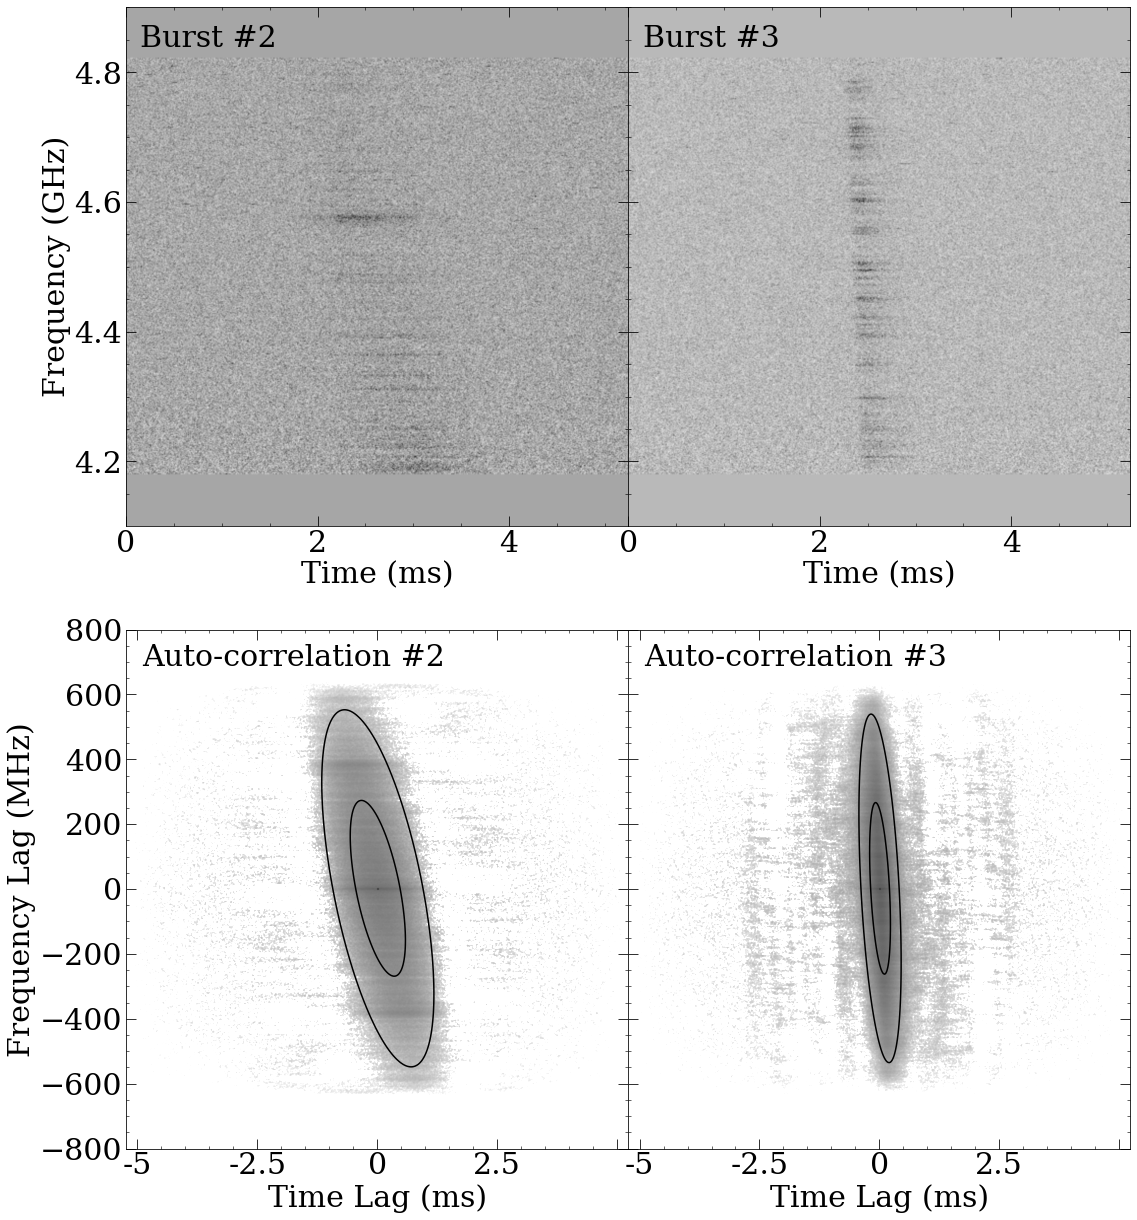

In [7]:
### Figure 4
plt.rcParams["font.family"] = "serif"
cmap = plt.get_cmap('gray_r')
cmap.set_bad(color = 'w', alpha = 1.) # potentially hides important errors in the data!

burstextents = [0, 
       10.24e-6 * burstwindow.shape[-1] * 1e3, 
       4100.78125 * 1e-3, 
       (4100.78125 + 1.5625*burstwindow.shape[-2]) * 1e-3]
corrextents = [-10.24e-6 * (corr.shape[1]/2) * 1e3, 
       10.24e-6 * (corr.shape[1]/2) * 1e3 , 
       (4100.78125 -  (2*4100.78125 + 1.5625*burstwindow.shape[0])/2 )*2, 
       ((4100.78125 + 1.5625*burstwindow.shape[-2]) -  (2*4100.78125 + 1.5625*burstwindow.shape[0])/2 )*2]

# plt.figure(figsize=(18,18))
plt.figure(figsize=(18,21))
# plt.title("Burst #{}".format(burst))
labelsize = 30
for burstdata, ploti, burstnum in zip([burst2data, burst3data], [1,2], [2,3]):
    plt.subplot(2, 2, ploti)
    ## Formatting
    plt.annotate('Burst #{}'.format(burstnum), (0.15, 4.84), size=labelsize)
    plt.xlabel("Time (ms)", size=labelsize)
    if ploti == 1: plt.ylabel('Frequency (GHz)', size=labelsize)
    labelleft = True if ploti == 1 else False
    plt.tick_params(labelsize=labelsize, direction='in', length=10, top=True, right=True, labelleft=labelleft)
    plt.tick_params(which='minor', direction='in', top=True, right=True, length=3)
    plt.minorticks_on()
    ## Burst spectrrum
    plt.imshow(burstdata['burstwindow'], cmap=cmap, interpolation='bicubic',aspect='auto', origin="lower", extent=burstextents)

    plt.subplot(2, 2, ploti+2)
    ## Formatting
    plt.annotate('Auto-correlation #{}'.format(burstnum), (-4.9, 690), size=labelsize)
    plt.xlabel('Time Lag (ms)', size=labelsize)
    if ploti+2 != 4: plt.ylabel('Frequency Lag (MHz)', size=labelsize)
    labelleft = True if ploti+2 != 4 else False
    plt.tick_params(labelsize=labelsize, direction='in', length=10, top=True, right=True, labelleft=labelleft)
    plt.tick_params(which='minor', direction='in', top=True, right=True, length=3)
    
    plt.minorticks_on()
    ## Corr spectrrum
    fullsigma = np.sqrt(burstdata['popt'][3]**2 + burstdata['popt'][4]**2)
    plt.imshow(burstdata['corr'], cmap=cmap, interpolation='bicubic', aspect='auto', origin="lower", norm=mcolors.LogNorm(vmin=1), extent=corrextents)
    plt.contour(burstdata['fitmap'], [burstdata['popt'][0]*0.13, burstdata['popt'][0]*0.61], colors='k', alpha=1, origin='lower', extent=corrextents)
    # plt.contour(burstdata['fitmap'], [burstdata['popt'][0]/4, burstdata['popt'][0]*0.9], colors='k', alpha=1, origin='lower', extent=corrextents)
    plt.xticks([-5, -2.5, 0, 2.5, 5], [str(x) for x in [-5, -2.5, 0, 2.5, '']])

# plt.subplots_adjust(wspace=-1.9)
plt.subplots_adjust(wspace=0)
# plt.tight_layout()
# for f in ['png', 'pdf', 'eps']: plt.savefig('paper_figures/burst2and3.{}'.format(f))

[111.48222725470062,
 6.749708479459105,
 7.793460963473907,
 3.246709336058745,
 3.2250095103092544,
 3.9144321659667836,
 5.526043142433374,
 9.157308395680246,
 3.218699593900001,
 3.290370671709115,
 3.4115435044866764,
 4.053156380451369,
 31.95620389349233,
 9.048346578597009,
 4.599277250304015,
 73.59034980033088]

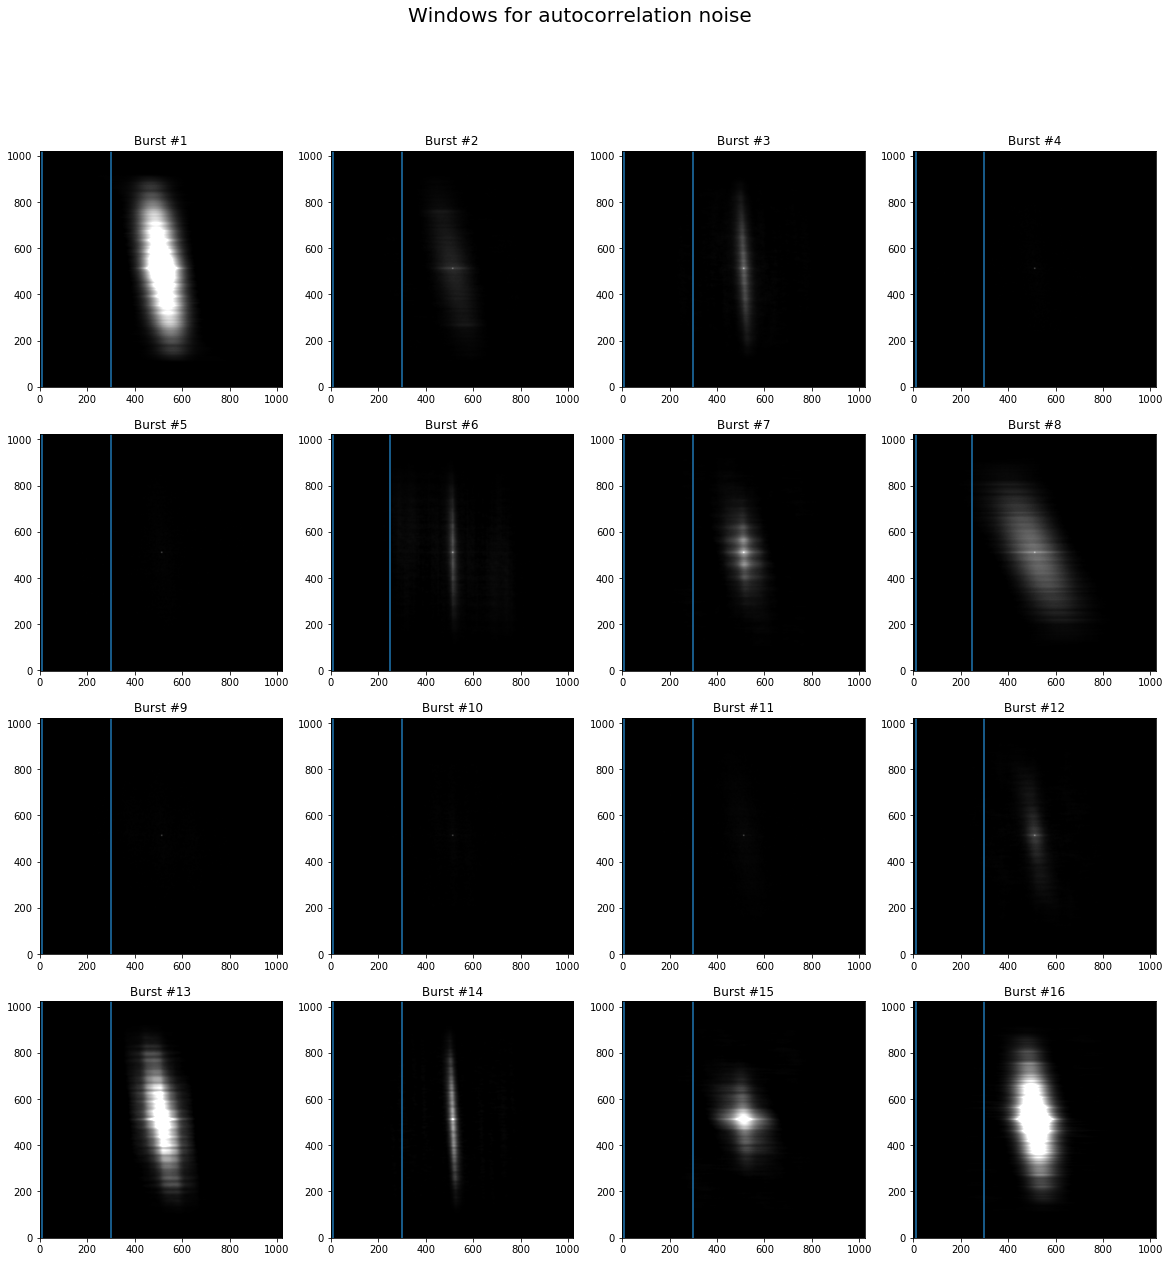

In [9]:
## Autocorrelation Noise Windows
titles = ["Burst #{}".format(x) for x in list(range(1, 17))]
corredges = [(10, 300),
             (10, 300),
             (10, 300),
             (10, 300),
             (10, 300),
             (10, 250),
             (10, 300),
             (10, 250),
             (10, 300),
             (10, 300),
             (10, 300),
             (10, 300),
             (10, 300),
             (10, 300),
             (10, 300),
             (10, 300)]
sigmas = []

plt.figure(figsize=(20, 20))
plt.suptitle('Windows for autocorrelation noise', size=20)
for title, ac, corredge in zip(titles, autocorrs, corredges):
    plt.subplot(4, 4, titles.index(title)+1)
    plt.title(title)
    plt.imshow(ac, aspect='auto', interpolation='bicubic', origin='lower', cmap='gray')
    plt.axvline(x=corredge[0]); plt.axvline(x=corredge[1])
    plt.clim(0, np.max(ac)/10)

    sigmas.append(np.std(ac[corredge[0]:corredge[1]]))

# slice ex.:
# plt.imshow(autocorrs[0][:,corredges[0][0]:corredges[0][1]], aspect='auto', interpolation='bicubic', origin='lower', cmap='gray')
# plt.clim(0, np.max(autocorrs[0])/10)
    
sigmas

In [3]:
popts, perrs

([array([1.81678443e+03, 5.12499356e+02, 5.12485033e+02, 1.73991316e+02,
         4.70716219e+01, 1.71656458e+00]),
  array([ 81.49221057, 512.49442555, 512.4783396 , 177.67605797,
          44.62740083,   8.05717689]),
  array([184.110978  , 512.4955582 , 512.35654137, 170.31670446,
          19.22062972,   1.62478075]),
  array([  4.22626838, 512.41515282, 511.9855525 , 159.27981853,
         -26.21396121,   1.70809064]),
  array([  5.53664047, 512.46314379, 512.82960322,  37.31701138,
         166.62822244,   3.2137215 ]),
  array([151.9528511 , 512.48735247, 512.39464578, 157.1408889 ,
          12.43800254,   1.59600775]),
  array([269.70713699, 512.49599945, 512.4839235 , 102.65223682,
          38.82269305,   1.719295  ]),
  array([246.10956198, 512.4948832 , 512.49278784, 171.61894454,
          64.50591015,   1.9922359 ]),
  array([  3.55513763, 512.31036773, 512.36846051, 133.4095558 ,
          89.61533044,   2.24302505]),
  array([  5.79253965, 512.44504316, 512.93472124, 1

In [13]:
perrs

,amplitude,xo,yo,sigmax,sigmay,theta,sigmax_error,sigmay_error,angle_error,red_chisq,drift_errors_raw,drifts_raw
name,,,,,,,,,,,,
M1,1816.784434,512.499356,512.485033,173.991316,47.071622,1.716565,0.011140,0.003007,0.000026,9.733683,0.190767,-1039.359422
M2,81.492211,512.494426,512.478340,177.676058,44.627401,8.057177,0.081784,0.020486,0.000174,3.818413,0.652317,-740.578570
M3,184.110978,512.495558,512.356541,170.316704,19.220630,1.624781,0.052822,0.005950,0.000050,4.049445,2.623174,-2823.770520
M4,4.226268,512.415153,511.985552,159.279819,-26.213961,1.708091,1.780140,0.292807,0.002672,3.318850,21.768613,-1104.400675
M5,5.536640,512.463144,512.829603,37.317011,166.628222,3.213722,0.258022,1.153948,0.002306,3.360715,67.749909,-2111.820516
M6,151.952851,512.487352,512.394646,157.140889,12.438003,1.596008,0.065385,0.005173,0.000047,6.719788,11.249634,-6051.049456
M7,269.707137,512.495999,512.483923,102.652237,38.822693,1.719295,0.019954,0.007547,0.000121,6.302707,0.845772,-1019.972935
M8,246.109562,512.494883,512.492788,171.618945,64.505910,1.992236,0.019619,0.007370,0.000071,6.146570,0.064490,-340.369797
M9,3.555138,512.310368,512.368461,133.409556,89.615330,2.243025,1.038778,0.697559,0.013465,3.361416,5.297999,-191.720255


In [17]:
# Export parameters and parameter erros
# popt is [amplitude, xo, yo, sigma_x, sigma_y, theta]
params = pd.merge(pd.DataFrame(popts, index=bursts.head(16).set_index('name').index, columns=['amplitude', 'xo', 'yo', 'sigmax', 'sigmay', 'theta']),
         pd.DataFrame(perrs, index=bursts.head(16).set_index('name').index, columns=['amp_error', 'xo_error', 'yo_error', 'sigmax_error', 'sigmay_error', 'angle_error']),
         how='left', on='name')

params['red_chisq']    = red_chisqs
params['drift_errors_raw'] = drift_errors  
params['drifts_raw'] = drifts  

params
# params.to_csv(parameterfile)

In [ ]:
cmap = plt.get_cmap('PiYG')
cmap.set_bad(color = 'k', alpha = 1.) # potentially hides important errors in the data!

plt.figure(figsize=(17,8))
plt.subplot(121)
plt.title("Burst #{}".format(burst))
burstextents = [0, 
       10.24e-6 * burstwindow.shape[-1] * 1e3, 
       4100.78125 * 1e-3, 
       (4100.78125 + 1.5625*burstwindow.shape[-2]) * 1e-3]
plt.imshow(burstwindow, cmap=cmap, interpolation='bicubic',aspect='auto', origin="lower", extent=burstextents)
plt.xlabel("Time (ms)", size=15)
plt.ylabel("Frequency (GHz)", size=15)
plt.clim(0, 0.3)
print(np.median(burstwindow))
plt.colorbar()

plt.subplot(122)
plt.title("Corr #{}. Fit: $\\nu_D$ = {:.2f} MHz/ms $\pm$ {:.2E}, peak = {:.0f}, $\sigma_x$ = {:.0f} $\sigma_y$ = {:.0f}".format(burst, drift, drift_error, np.max(corr), popt[3], popt[4]))
# plt.imshow(corr, cmap=cmap, interpolation='bicubic',aspect='auto', origin="lower") # linear scale
# plt.clim(0, np.max(corr)/2)
corrextents = [-10.24e-6 * (corr.shape[1]/2) * 1e3, 
       10.24e-6 * (corr.shape[1]/2) * 1e3 , 
       (4100.78125 -  (2*4100.78125 + 1.5625*burstwindow.shape[0])/2 )*2, 
       ((4100.78125 + 1.5625*burstwindow.shape[-2]) -  (2*4100.78125 + 1.5625*burstwindow.shape[0])/2 )*2]
plt.imshow(corr, cmap=cmap, interpolation='bicubic', aspect='auto', origin="lower", norm=mcolors.LogNorm(vmin=1), extent=corrextents)
plt.xlabel("Time Shift (ms)", size=15)
plt.ylabel("Frequency Shift (MHz)", size=15)
plt.colorbar()

plt.contour(fitmap2, [popt[0]/4, popt[0]*0.9], colors='w', alpha=0.5, origin='lower', extent=corrextents)

plt.tight_layout()

In [ ]:
plt.figure(figsize=(10,10))
cmap = plt.get_cmap('gray')
cmap.set_bad(color = 'k', alpha = 1.)
plt.imshow(corr, cmap=cmap, interpolation='bicubic', aspect='auto', origin="lower", norm=mcolors.LogNorm(vmin=1))
print(np.max(corr), np.min(corr))
# linear cmap
# plt.imshow(corr, cmap=cmap, interpolation='bicubic', aspect='auto', origin="lower")
# plt.clim(0, np.max(corr)/2)

plt.colorbar()


In [ ]:
cmap = "gray"
x = range(0, 1023); y = range(0, 1023)
x, y = np.meshgrid(x, y)
# amplitude, xo, yo, sigma_x, sigma_y, theta
testmap = twoD_Gaussian((x, y), *[1.8e+03, 5.11e+02, 5.11e+02, 1.74e+02, 4.7e+01, 1.425]).reshape(1023, 1023)
popt = [1.8e+03, 5.11e+02, 5.11e+02, 1.74e+02, 4.7e+01, 1.425]

plt.figure(figsize=(10,8))
plt.title("Correlation #{}. Fit: $\\theta$ = {:.2f} rad, peak = {:.0f}, $\sigma_x$ = {} $\sigma_y$ = {}".format(burst, popt[-1], 1000, 1, 1))
print(burstwindow.shape)
burstextents = [0, 
           10.24e-6 * burstwindow.shape[-1] * 1e3, 
           4100.78125 * 1e-3, 
           (4100.78125 + 1.5625*burstwindow.shape[-2]) * 1e-3]

plt.imshow(burstwindow, cmap=cmap, interpolation='bicubic',aspect='auto', origin="lower", extent=burstextents)
plt.xlabel("Time (ms)", size=20)
plt.ylabel("Frequency (GHz)", size=20)
plt.colorbar()


In [ ]:
x = range(0, 1023); y = range(0, 1023)
x, y = np.meshgrid(x, y)
popt = [1,2,3,4,5,6]; burst = 1
fitmap2 = twoD_Gaussian((x, y), *popt).reshape(1023, 1023)
drift = 1; perr = 1
cmap = "gray"
plt.figure(figsize=(10,10))
plt.title("Corr #{}. Fit: $\\nu_D$ = {:.2f} MHz/ms $\pm$ {:.2f}, peak = {:.0f}, $\sigma_x$ = {:.0f} $\sigma_y$ = {:.0f}".format(1,1,1,1,1,1))
# plt.title("TESTCorr #{}. Fit: $\\theta$ = {:.2f}rad, peak = {:.0f}, $\sigma_x$ = {:.0f} $\sigma_y$ = {:.0f}".format(burst, popt[-1], np.max(corr), popt[3], popt[4]))
# corrextents = [-10.24e-6 * corr.shape[1] * 1e3 / 2, 
#            10.24e-6 * corr.shape[1] * 1e3 / 2, 
#            (4100.78125 -  (4100.78125 + 1.5625*corr.shape[0]/2) ) * 1e-3, 
#            (4100.78125 +  (4100.78125 + 1.5625*corr.shape[0]/2) ) * 1e-3]
plt.imshow(fitmap2, cmap=cmap, interpolation='bicubic', aspect='auto', origin="lower", norm=mcolors.LogNorm(vmin=1))#, extent=corrextents)
plt.colorbar()
# plt.contour(fitmap2, [popt[0]/4, popt[0]*0.9], colors='w', alpha=0.5, origin='lower', extent=corrextents)

In [ ]:
corrextents = [-10.24e-6 * (corr.shape[1]/2) * 1e3, 
           10.24e-6 * (corr.shape[1]/2) * 1e3 , 
           (4100.78125 -  (2*4100.78125 + 1.5625*burstwindow.shape[0])/2 )*2, 
           ((4100.78125 + 1.5625*burstwindow.shape[-2]) -  (2*4100.78125 + 1.5625*burstwindow.shape[0])/2 )*2]
corrextents